In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.models.video import r2plus1d_18
from torchvision.io import read_video
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os

In [24]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, frame_count, resize, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.classes.sort()
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.frame_count = frame_count
        self.resize = resize

        for idx, action_class in enumerate(self.classes):
            class_path = os.path.join(root_dir, action_class)
            for video_file in os.listdir(class_path):
                if video_file.endswith(('.mp4', '.avi')) and not video_file.startswith('.'):
                    self.data.append(os.path.join(class_path, video_file))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data[idx]
        label = self.labels[idx]
        video, _, _ = read_video(video_path)
    
        # Process video
        video = self.process_video(video)
    
        if self.transform:
            video = self.transform(video)


        return video, label

    import torch

    def process_video(self, video):
        # video is a tensor of shape [frames, height, width, channels]
        video = video.float()
    
        resized_frames = []
        for i in range(min(self.frame_count, video.shape[0])):
            frame = video[i]
    
            # Convert to RGB if grayscale
            if frame.size(2) == 1:
                frame = frame.repeat(1, 1, 3)
    
            # Permute to [channels, height, width]
            frame = frame.permute(2, 0, 1)
    
            # Resize frame
            frame = F.interpolate(frame.unsqueeze(0), size=self.resize, mode='bilinear', align_corners=False).squeeze(0)
    
            resized_frames.append(frame)
    
        # Pad if necessary
        while len(resized_frames) < self.frame_count:
            resized_frames.append(resized_frames[-1])
    
        # Stack and permute to [channels, frames, height, width]
        video_tensor = torch.stack(resized_frames, dim=0).permute(1, 0, 2, 3)
    
        return video_tensor


In [35]:
# Initialize dataset
root_dir = 'videos'
frame_count = 16
resize = (224, 224)
dataset = VideoDataset(root_dir, frame_count, resize)

labels = dataset.labels

# Create data loader for test sets

test_loader = DataLoader(dataset, batch_size=16, shuffle=False)

In [36]:
# PATH = 'r2plus1d_model_b2.pth'
PATH = 'r2plus1d_model_b16.pth'
model = r2plus1d_18()
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(PATH))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

C:\Users\temirlan.nurbay\AppData\Roaming\Python\Python310\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
ac-tex damaged at 8 6
Error at MB: 74


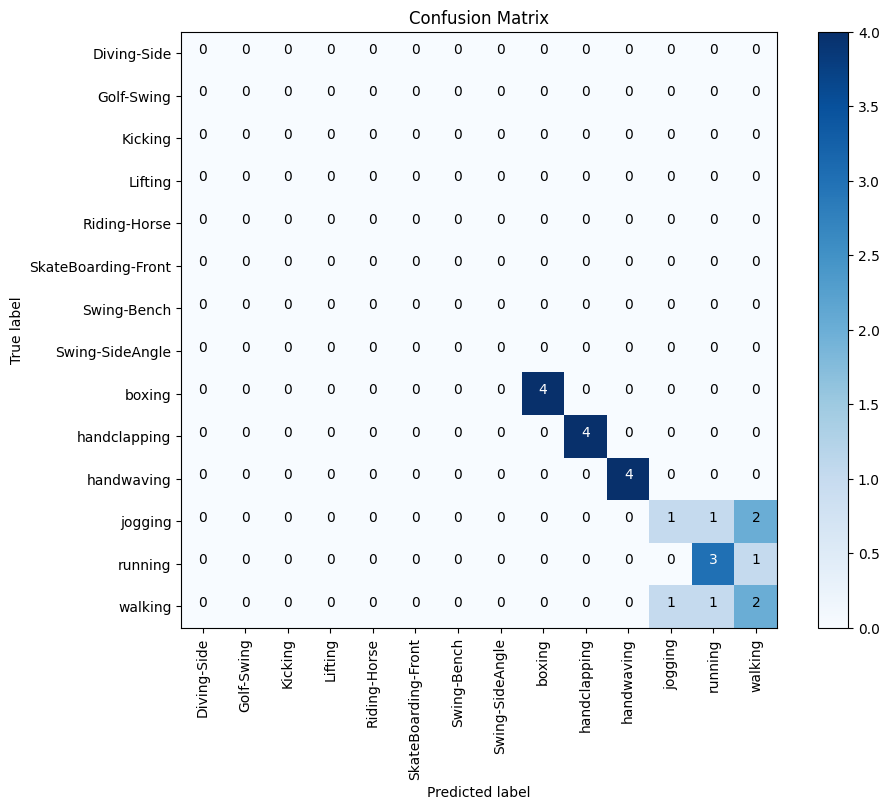


Accuracy for class Diving-Side:
  Top-1: No samples available for this class.
  Top-3: No samples available for this class.
  Top-5: No samples available for this class.

Accuracy for class Golf-Swing:
  Top-1: No samples available for this class.
  Top-3: No samples available for this class.
  Top-5: No samples available for this class.

Accuracy for class Kicking:
  Top-1: No samples available for this class.
  Top-3: No samples available for this class.
  Top-5: No samples available for this class.

Accuracy for class Lifting:
  Top-1: No samples available for this class.
  Top-3: No samples available for this class.
  Top-5: No samples available for this class.

Accuracy for class Riding-Horse:
  Top-1: No samples available for this class.
  Top-3: No samples available for this class.
  Top-5: No samples available for this class.

Accuracy for class SkateBoarding-Front:
  Top-1: No samples available for this class.
  Top-3: No samples available for this class.
  Top-5: No samples 

In [38]:
model.eval()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Initialize top-k correct prediction counters
topk_correct = {k: np.zeros(len(dataset.classes)) for k in [1, 3, 5]}
topk_total = np.zeros(len(dataset.classes))

# Initialize confusion matrix
conf_matrix = np.zeros((len(dataset.classes), len(dataset.classes)), dtype=int)

# Process each batch in test_loader
with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(device)
        labels = labels.to(device)
        outputs = model(videos)
        
        # Get top-5 predictions
        _, top5 = outputs.topk(5, 1, True, True)
        
        for i, label in enumerate(labels):
            y_true.append(label.item())
            y_pred.append(top5[i, 0].item())  # Add top-1 prediction for the confusion matrix
            topk_total[label.item()] += 1
            
            # Check if the true label is in the top k predictions
            true_label = label.item()
            pred_labels = top5[i].tolist()
            for k in [1, 3, 5]:
                if true_label in pred_labels[:k]:
                    topk_correct[k][true_label] += 1

conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(len(dataset.classes))))

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90) 
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(conf_matrix, dataset.classes)

# Calculate and print Top-1, Top-3, and Top-5 accuracies for each class
for i, class_name in enumerate(dataset.classes):
    print(f"\nAccuracy for class {class_name}:")
    for k in [1, 3, 5]:
        if topk_total[i] > 0:
            accuracy = (topk_correct[k][i] / topk_total[i]) * 100
            print(f"  Top-{k}: {accuracy:.2f}%")
        else:
            print(f"  Top-{k}: No samples available for this class.")


In [6]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, frame_count, resize, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.identifiers = [] 
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.frame_count = frame_count
        self.resize = resize

        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for video_file in os.listdir(class_path):
                if video_file.endswith(('.mp4', '.avi')) and not video_file.startswith('.'):
                    video_path = os.path.join(class_path, video_file)
                    self.data.append(video_path)
                    self.labels.append(self.class_to_idx[class_name])
                    self.identifiers.append(video_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data[idx]
        video, _, _ = read_video(video_path, pts_unit='sec')
        video = self.process_video(video) 
        label = self.labels[idx]
        identifier = self.identifiers[idx]
        return video, label, identifier

    def process_video(self, video):
        # video is a tensor of shape [frames, height, width, channels]
    
        video = video.float()
    
        resized_frames = []
        for i in range(min(self.frame_count, video.shape[0])):
            frame = video[i]
    
            # Convert to RGB if grayscale
            if frame.size(2) == 1:
                frame = frame.repeat(1, 1, 3)
    
            # Permute to [channels, height, width]
            frame = frame.permute(2, 0, 1)
    
            # Resize frame
            frame = F.interpolate(frame.unsqueeze(0), size=self.resize, mode='bilinear', align_corners=False).squeeze(0)
    
            resized_frames.append(frame)
    
        # Pad if necessary
        while len(resized_frames) < self.frame_count:
            resized_frames.append(resized_frames[-1])
    
        # Stack and permute to [channels, frames, height, width]
        video_tensor = torch.stack(resized_frames, dim=0).permute(1, 0, 2, 3)
    
        return video_tensor


In [ ]:
# Initialize the dataset and DataLoader
test_dataset = VideoDataset(root_dir='video_for_b16_e25', frame_count=16, resize=(224, 224))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
misclassified = []

with torch.no_grad():
    for video, true_label, identifier in test_loader:
        video = video.to(device)
        true_label = true_label.to(device)

        # Get the model's predictions
        outputs = model(video)
        _, predicted_label = torch.max(outputs, 1)

        # Check for misclassifications
        if predicted_label != true_label:
            misclassified.append((identifier[0], true_label.item(), predicted_label.item()))

# Output the misclassified videos
for identifier, true_label, predicted_label in misclassified:
    print(f"Video {identifier} was misclassified as {test_dataset.classes[predicted_label]} (True class: {test_dataset.classes[true_label]})")
